## 라이브러리

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling.profile_report as report

import re
import seaborn as sns
sns.set(style = 'white')
import matplotlib.pyplot as plt
from xgboost import plot_importance
%matplotlib inline
import matplotlib.ticker as mtick # For specifying the axes tick format 

import warnings
warnings.filterwarnings('ignore')

# Label Encoding
from sklearn.preprocessing import LabelEncoder

# modeling
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold

from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay

from scipy.special import softmax

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMClassifier
import shap

C:\Users\Playdata\AppData\Local\Temp\ipykernel_17024\68649052.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling.profile_report as report


# 1. 데이터 확인

## 데이터 불러오기

In [2]:
prc = pd.read_csv('C:/Users/Playdata/Desktop/미니프젝1/archive/telecom_customer_churn.csv', encoding='euc-kr')
# 데이터 파악
prc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              7043 non-null   objec

Churn Category와 Churn Reason이 null값이 많음을 알 수 있다.

In [3]:
# 데이터 통계량 파악
prc.describe()

,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,6361.000000,5517.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,93486.070567,36.197455,-119.756684,1.951867,32.386767,25.420517,26.189958,63.596131,2280.381264,1.962182,6.860713,749.099262,3034.379056
std,16.750352,0.962802,1856.767505,2.468929,2.154425,3.001199,24.542061,14.200374,19.586585,31.204743,2266.220462,7.902614,25.104978,846.660055,2865.204542
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,0.000000,1.000000,1.010000,2.000000,-10.000000,18.800000,0.000000,0.000000,0.000000,21.360000
25%,32.000000,0.000000,92101.000000,33.990646,-121.788090,0.000000,9.000000,13.050000,13.000000,30.400000,400.150000,0.000000,0.000000,70.545000,605.610000
50%,46.000000,0.000000,93518.000000,36.205465,-119.595293,0.000000,29.000000,25.690000,21.000000,70.050000,1394.550000,0.000000,0.000000,401.440000,2108.640000
75%,60.000000,0.000000,95329.000000,38.161321,-117.969795,3.000000,55.000000,37.680000,30.000000,89.750000,3786.600000,0.000000,0.000000,1191.100000,4801.145000
max,80.000000,9.000000,96150.000000,41.962127,-114.192901,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000


In [4]:
# 변수명 변경
prc.rename(lambda x: x.lower().strip().replace(' ', '_'), axis='columns', inplace=True)

# 2. 데이터 전처리

### 2-1. 중복값

In [5]:
print(prc.duplicated('customer_id', keep=False).sum())

0


고객명으로 중복확인시 중복값 없음을 알 수 있음

### 2-2.결측치

In [6]:
# 결측치 개수 파악
prc.isnull().sum().to_frame('nan_count')

,nan_count
customer_id,0
gender,0
age,0
married,0
number_of_dependents,0
city,0
zip_code,0
latitude,0
longitude,0
number_of_referrals,0


In [7]:
# 평균값으로 채워줄 시
prc['avg_monthly_long_distance_charges'] = prc['avg_monthly_long_distance_charges'].fillna(prc['avg_monthly_long_distance_charges'].mean())

prc.multiple_lines = prc.multiple_lines.fillna('No Phone Service')

Phone Service를 사용하지 않으면 Avg Monthly Long Distance Charges와 Multiple Lines가 null 값이므로 Avg Monthly Long Distance Charges는 평균을, Multiple Lines는 No Phone Service로 null값을 채워줌

In [8]:
no_internet_service = ['internet_type', 'online_security', 'online_backup', 'device_protection_plan','premium_tech_support',
                       'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data']
prc[no_internet_service] = prc[no_internet_service].fillna('No Internet Service')

# 평균값으로 채워줄 시
prc['avg_monthly_gb_download'] = prc['avg_monthly_gb_download'].fillna(prc['avg_monthly_gb_download'].mean())

Internet Service를 사용하지 않으면 위의 컬럼들이 다 null값으로 표현되므로 Avg Monthly GB Download는 평균으로 나머지는 No Internet Service로 null값을 채워줌

Churn Category와 Churn Reason은 이탈한 이유와 카테고리임으로 이탈이유 시각화 후 drop 처리할 예정이므로 즉시 결측치 처리하지 않음

### 2-3. feature

### churn(이탈여부 yes/no) 컬럼 추가
- customer_status = joined 제외
- customer_status = churned : yes
- customer_status = stayed : no

예측의 편향성을 피하기 위해 최근 계약 고객(customer_status) 중 joined(계약 유지 기간 1,2,3임)을 제외

In [9]:
prc = prc[prc['customer_status']!= 'Joined']

prc['churn'] = np.where(prc['customer_status'] == 'Churned', 'Yes', 'No')

# 3. 데이터 시각화 / EDA

<AxesSubplot: xlabel='tenure_in_months', ylabel='monthly_charge'>

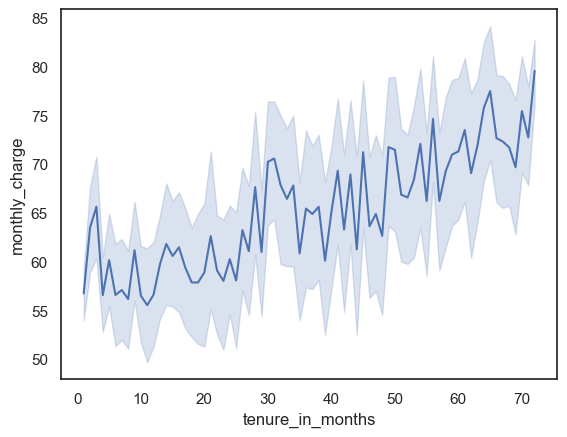

In [10]:
sns.lineplot(data = prc, x='tenure_in_months', y='monthly_charge')

계약 유지 기간이 길면 월별 금액이 높은 것을 알 수 있음

In [11]:
prc.groupby('churn')['monthly_charge'].describe()
prc.groupby('churn')['total_charges'].describe()
prc.groupby(['churn', 'gender'])['monthly_charge'].describe()

count       mean        std   min      25%     50%     75%  \
churn gender                                                                
No    Female  2338.0  62.343926  32.085856 -10.0  25.2500  65.625  89.750   
      Male    2382.0  61.142107  32.304853 -10.0  25.0125  65.550  89.375   
Yes   Female   939.0  73.606656  26.093400 -10.0  59.6250  79.500  93.625   
      Male     930.0  73.086022  26.665339  -9.0  53.8750  79.500  94.500   

                 max  
churn gender          
No    Female  118.75  
      Male    118.20  
Yes   Female  117.45  
      Male    118.35

<AxesSubplot: xlabel='tenure_in_months', ylabel='total_revenue'>

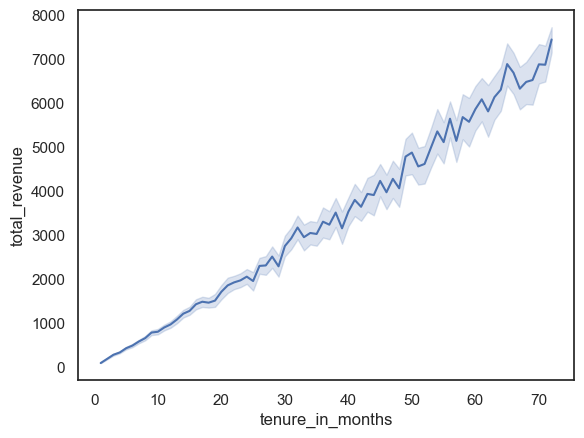

In [12]:
sns.lineplot(data = prc, x='tenure_in_months', y='total_revenue')

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

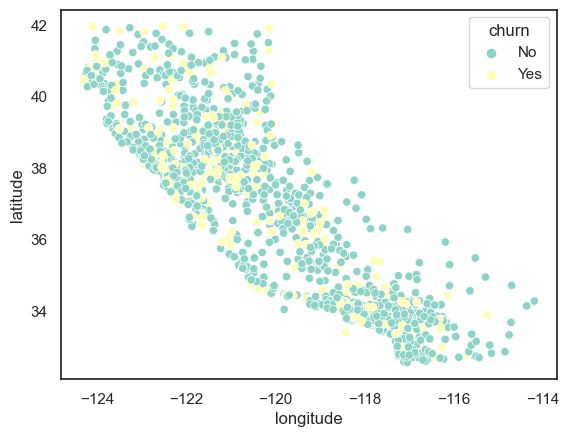

In [13]:
sns.scatterplot(data = prc, x='longitude', y='latitude', hue='churn', palette = 'Set3')

지역별로 보았을 때 한 곳에 이탈 고객이 몰려있거나 하는 특징이 없음을 알 수 있음

zip code, latitude, longitude, city 컬럼 제외

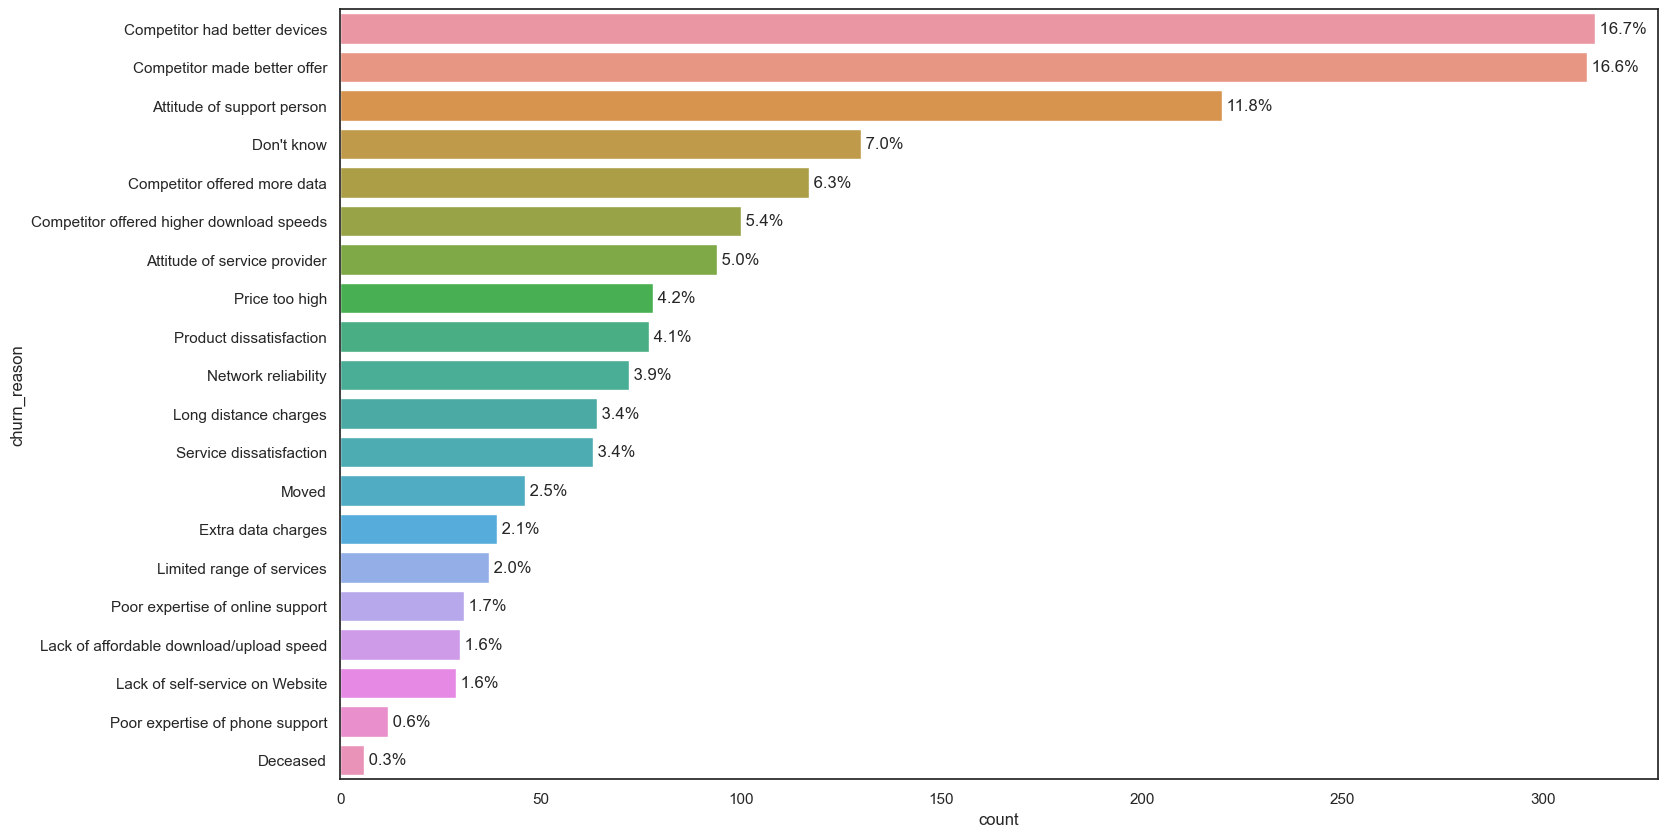

In [14]:
# 이탈 여부 이유 count
# order 사용하여 내림차순으로 정렬
fig, ax = plt.subplots(figsize=(17,10))
churn_reason = prc['churn_reason'].dropna()
sns.countplot(data=prc, y=churn_reason, ax=ax, order=prc['churn_reason'].value_counts().index)
total = len(churn_reason)
for p in ax.patches: # ax.patches : 그래프 위에 비율 쓰고 싶을 때 사용하는 메소드
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(' '+percentage, (x,y), ha='left', va='center', fontsize=12)
plt.show()

age                                     AxesSubplot(0.125,0.786098;0.133621x0.0939024)
number_of_dependents                 AxesSubplot(0.285345,0.786098;0.133621x0.0939024)
zip_code                              AxesSubplot(0.44569,0.786098;0.133621x0.0939024)
latitude                             AxesSubplot(0.606034,0.786098;0.133621x0.0939024)
longitude                            AxesSubplot(0.766379,0.786098;0.133621x0.0939024)
number_of_referrals                     AxesSubplot(0.125,0.673415;0.133621x0.0939024)
tenure_in_months                     AxesSubplot(0.285345,0.673415;0.133621x0.0939024)
avg_monthly_long_distance_charges     AxesSubplot(0.44569,0.673415;0.133621x0.0939024)
avg_monthly_gb_download              AxesSubplot(0.606034,0.673415;0.133621x0.0939024)
monthly_charge                       AxesSubplot(0.766379,0.673415;0.133621x0.0939024)
total_charges                           AxesSubplot(0.125,0.560732;0.133621x0.0939024)
total_refunds                        AxesSu

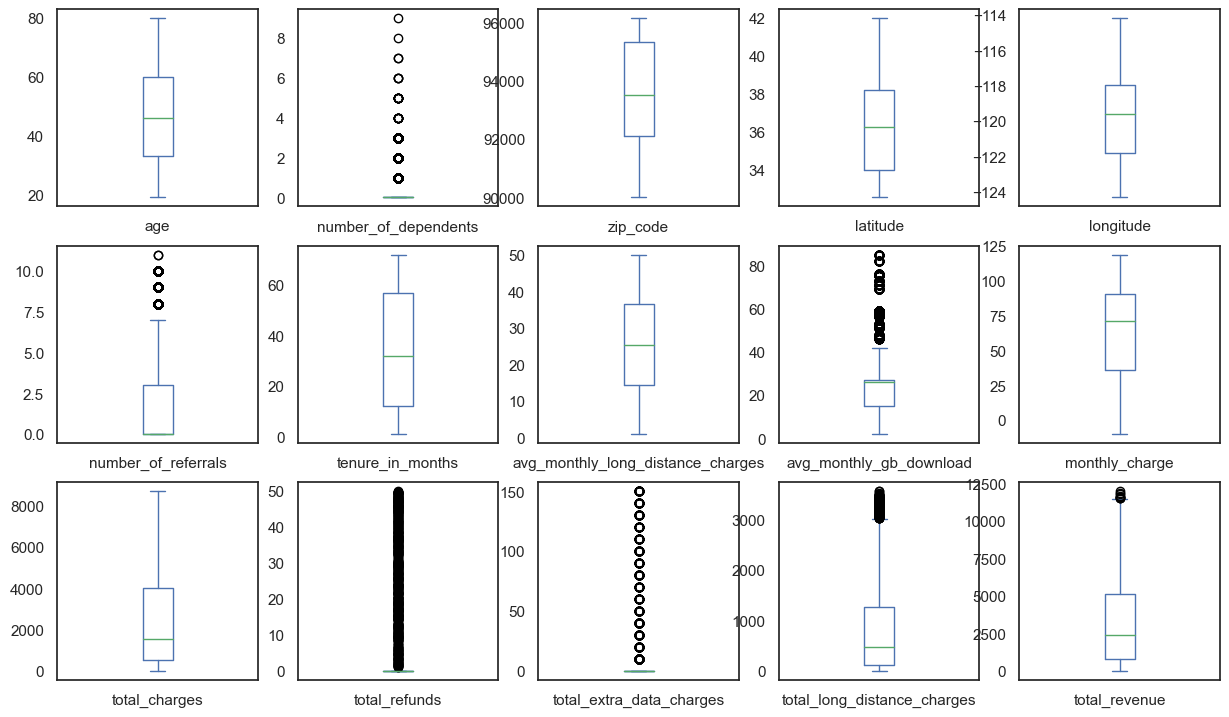

In [15]:
prc.plot(kind='box', subplots=True, layout=(7, 5), figsize=(15, 21))

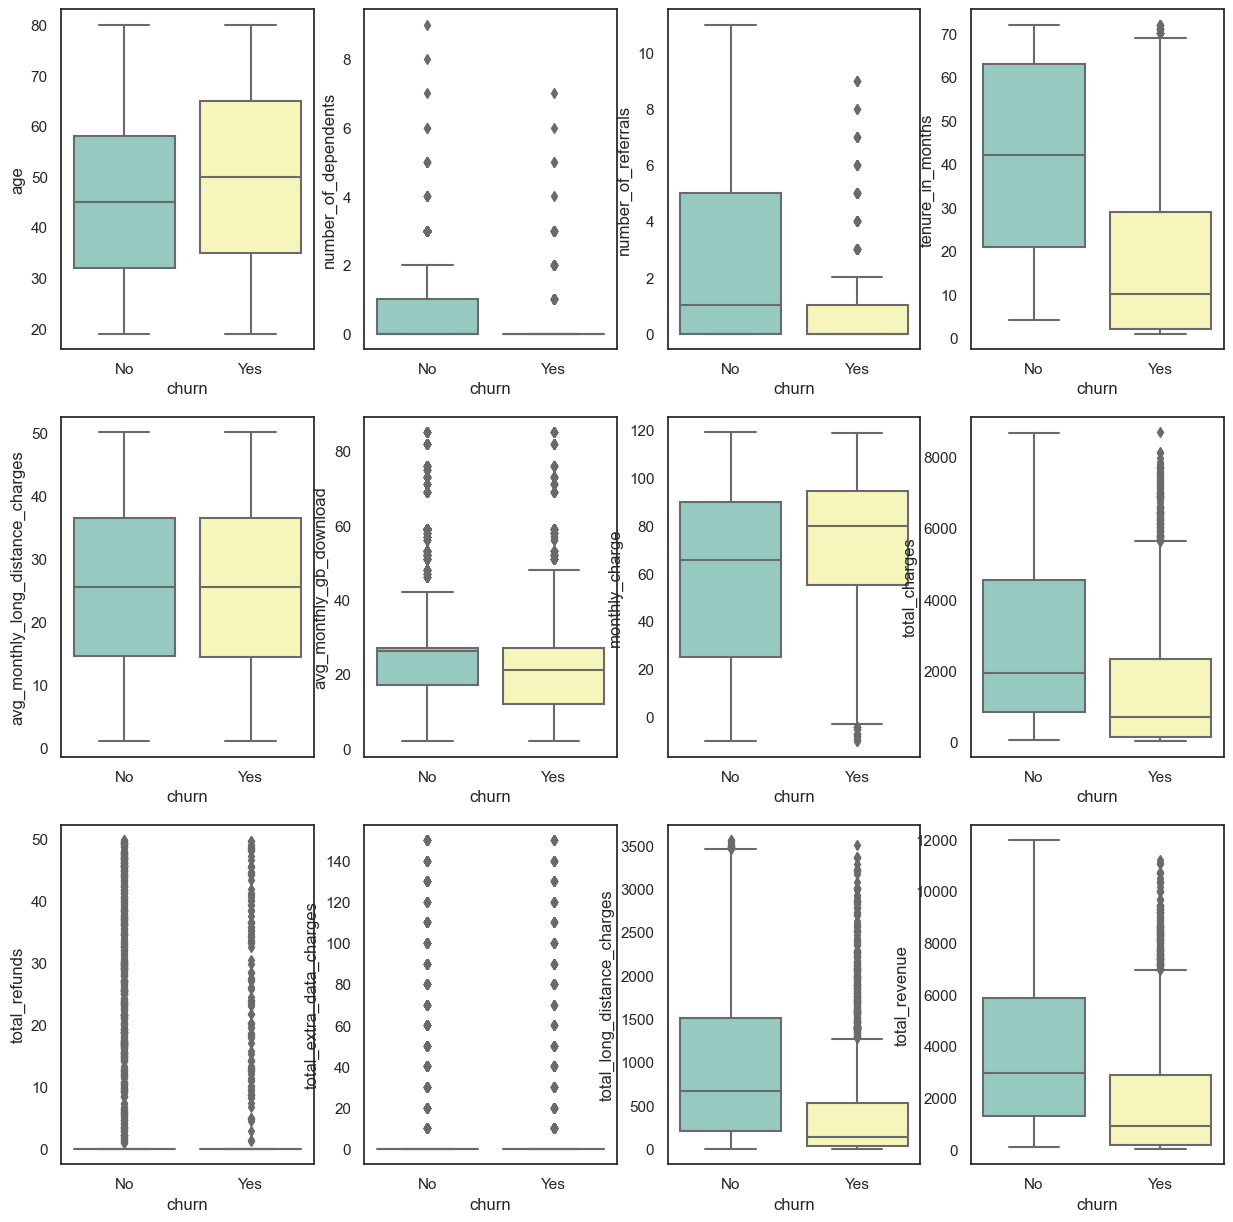

In [16]:
number_col = ['age', 'number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges',
              'avg_monthly_gb_download', 'monthly_charge', 'total_charges', 'total_refunds', 'total_extra_data_charges',
              'total_long_distance_charges', 'total_revenue']
fig, ax = plt.subplots(3,4, figsize = (15,15))
for i, subplot in zip(number_col, ax.flatten()):
    sns.boxplot(x = 'churn', y = i , data = prc, ax = subplot, palette = 'Set3')

- number of dependents

대부분의 고객은 부양가족이 없습니다.

- monthly charge

이탈 고객의 월간 요금 중앙값이 충성고객의 월간 요금 중앙값보다 높다는 것을 알 수 있습니다.

요금이 너무 높으면 고객이 이탈할 가능성이 더 높다고 생각할 수 있습니다.

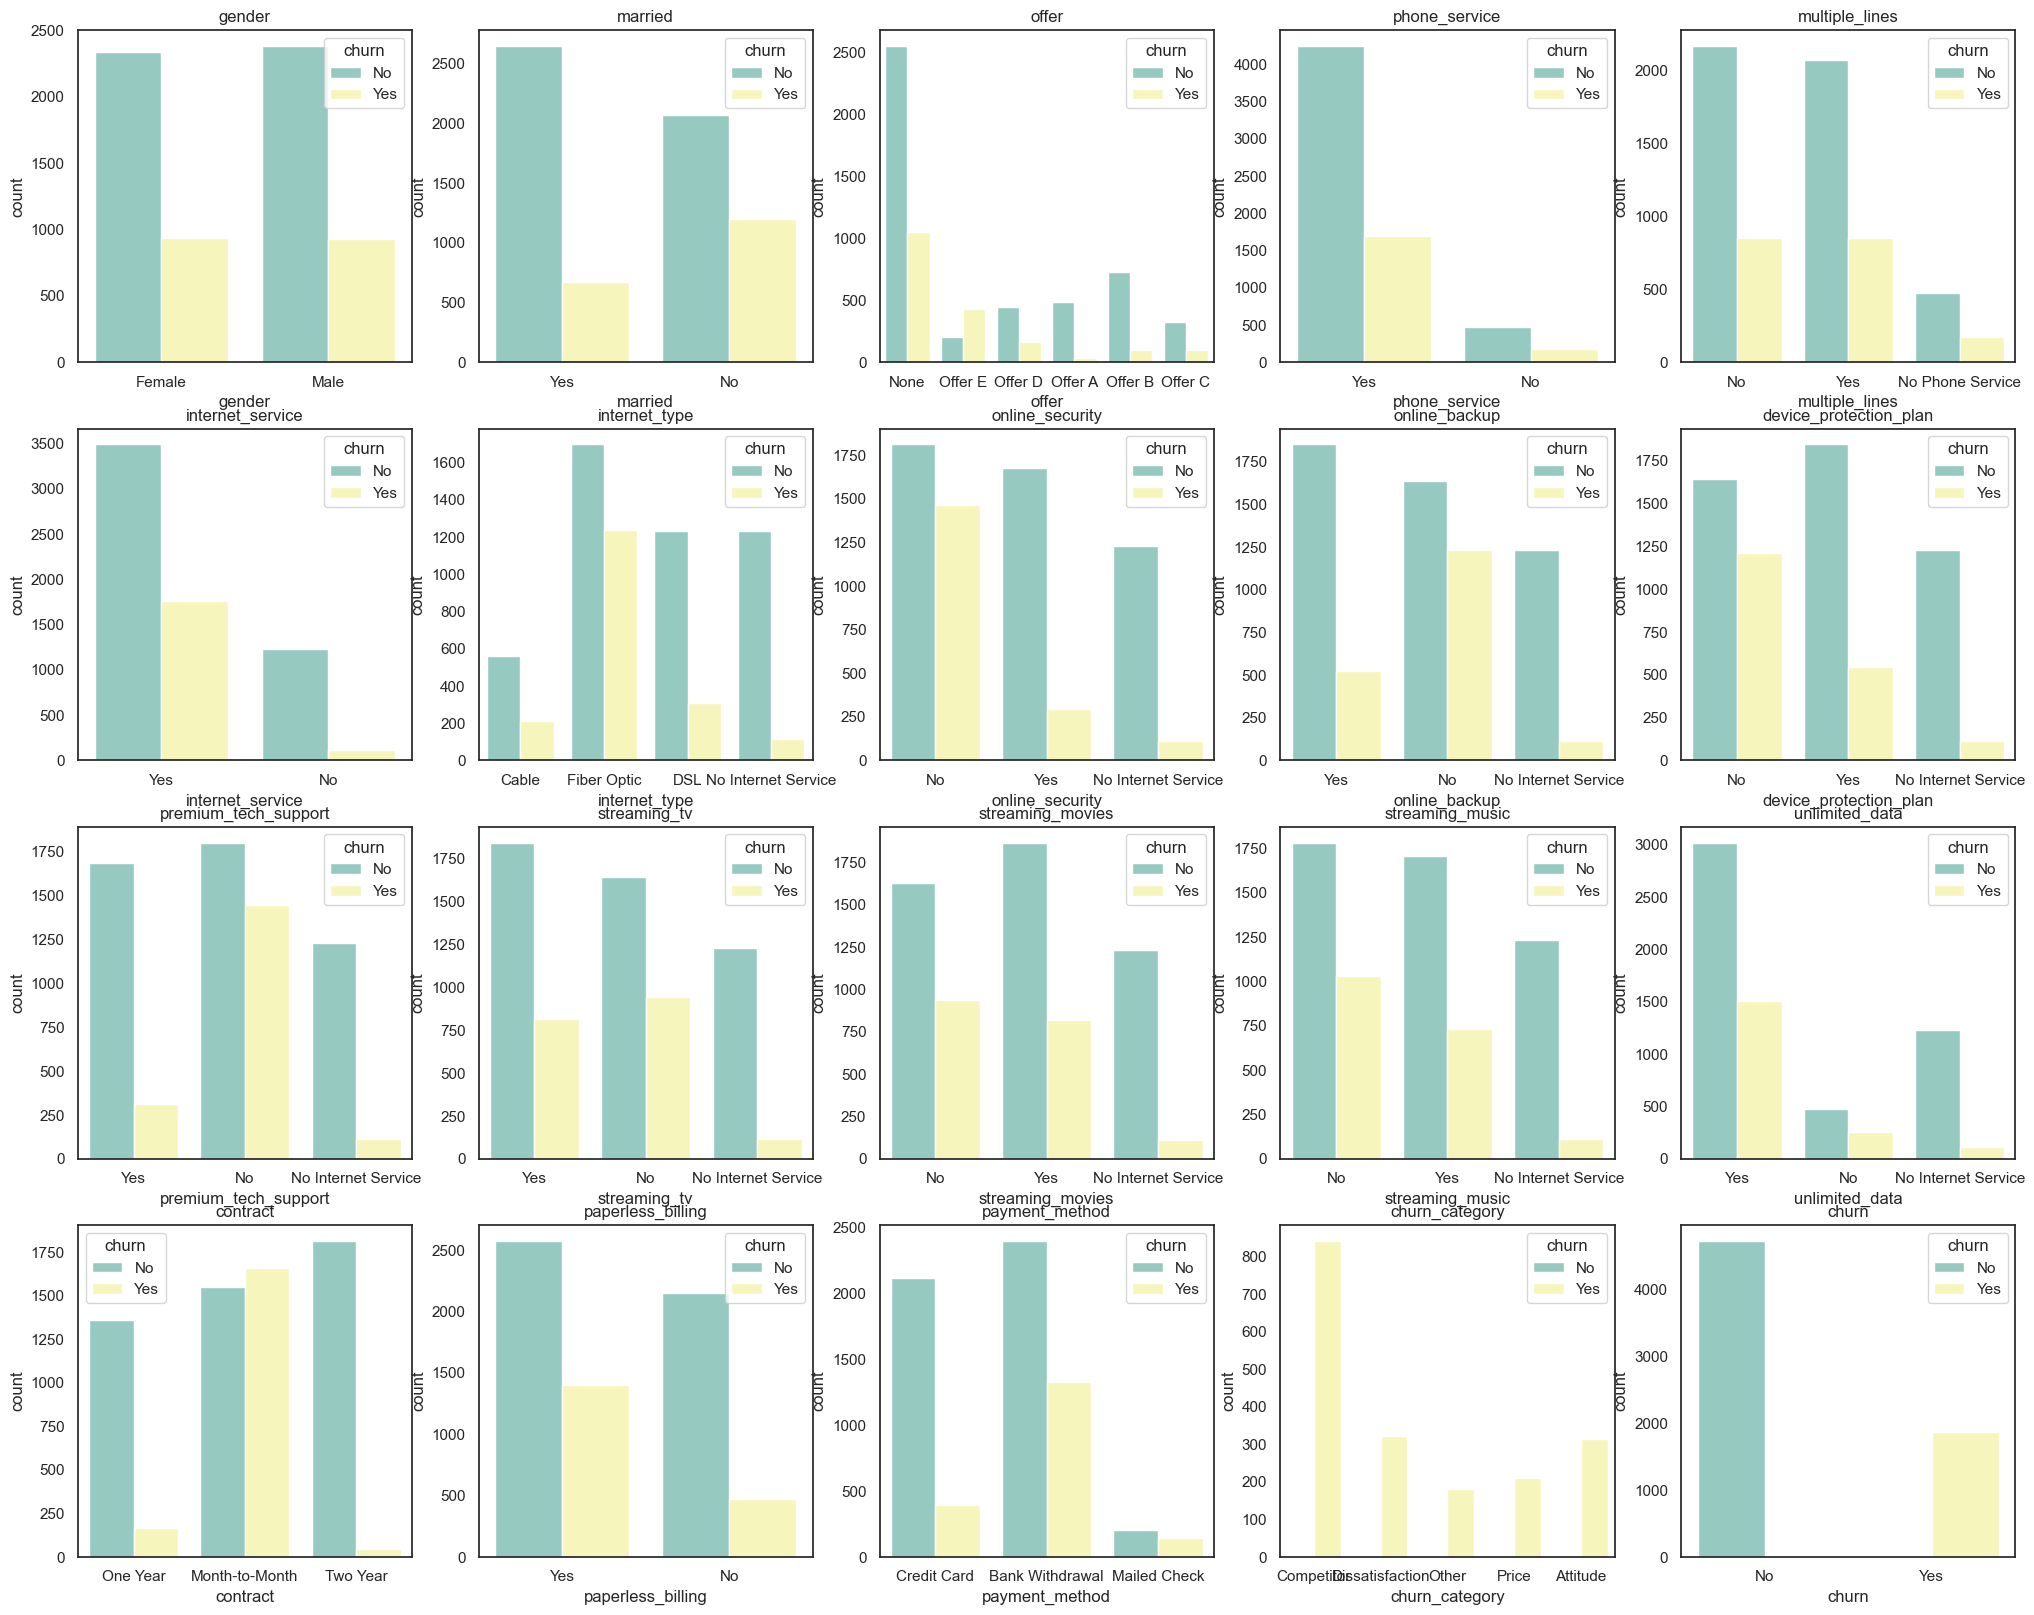

In [17]:
object_col = ['gender', 'married', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type',
              'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv',
              'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method',
              'churn_category', 'churn']
plt.figure(figsize=(25,25))

for i, col in enumerate(object_col):
    ax = plt.subplot(5, 5, i+1)
    sns.countplot(x =str(col), hue = 'churn', data = prc, palette = 'Set3')
    ax.set_title(f"{col}")

- offer

대부분의 고객은 마케팅 제안을 수락하지 않았습니다.

기업은 낮은 마케팅율을 개선하기를 바랄 수 있습니다.

마케팅 제안 E를 구독한 후 높은 고객 이탈률을 관찰했습니다.

- multiple lines

multiple lines는 충성고객과 이탈 고객이 균등하게 분배되어 있으므로 고객 이탈 여부에 영향을 미치지 않을 것이라고 생각할 수 있습니다.

- internet service

인터넷 서비스에 가입하면 이탈율이 높아집니다.

결합해서 쓰는 경우 이탈율 높아짐. (인터넷 서비스만 26.4% 폰서비스만 8.4% 같이 쓰는 경우 34.5%)

- internet type

다양한 인터넷 연결 유형 중 Fiber Optic이 가장 널리 사용됩니다.

Cable 및 DSL에 비해 가격이 비싸더라도 다운로드 및 업로드 속도가 가장 빠르기 때문입니다.

요금이 비싼 데 비하여, 통신사쪽 메리트가 없음(그래서 이탈율 up)

- online security, online backup, device protection plan

이탈 고객은 이 기능을 구매(선택)할 가능성이 거의 없습니다.

- premium tech support

많은 이탈 고객이 premium tech support를 받지 않았습니다.

기술적 문제가 이탈 결정에 영향을 미칠 수도 있다는 것을 알 수 있습니다.

- streaming tv, movies, music

streaming tv, movies, music은 충성고객과 이탈고객의 큰 차이가 없이 균등해 보이므로 고객 이탈 여부에 영향을 미치지 않을 것이라고 생각할 수 있습니다.

- unlimited data

많은 고객에게 무제한 데이터가 인기가 있습니다.

- contract

월 단위로 지불하는 사용자는 이탈할 가능성이 높습니다.

하지만 대부분의 충성 고객은 1, 2년 계약입니다.

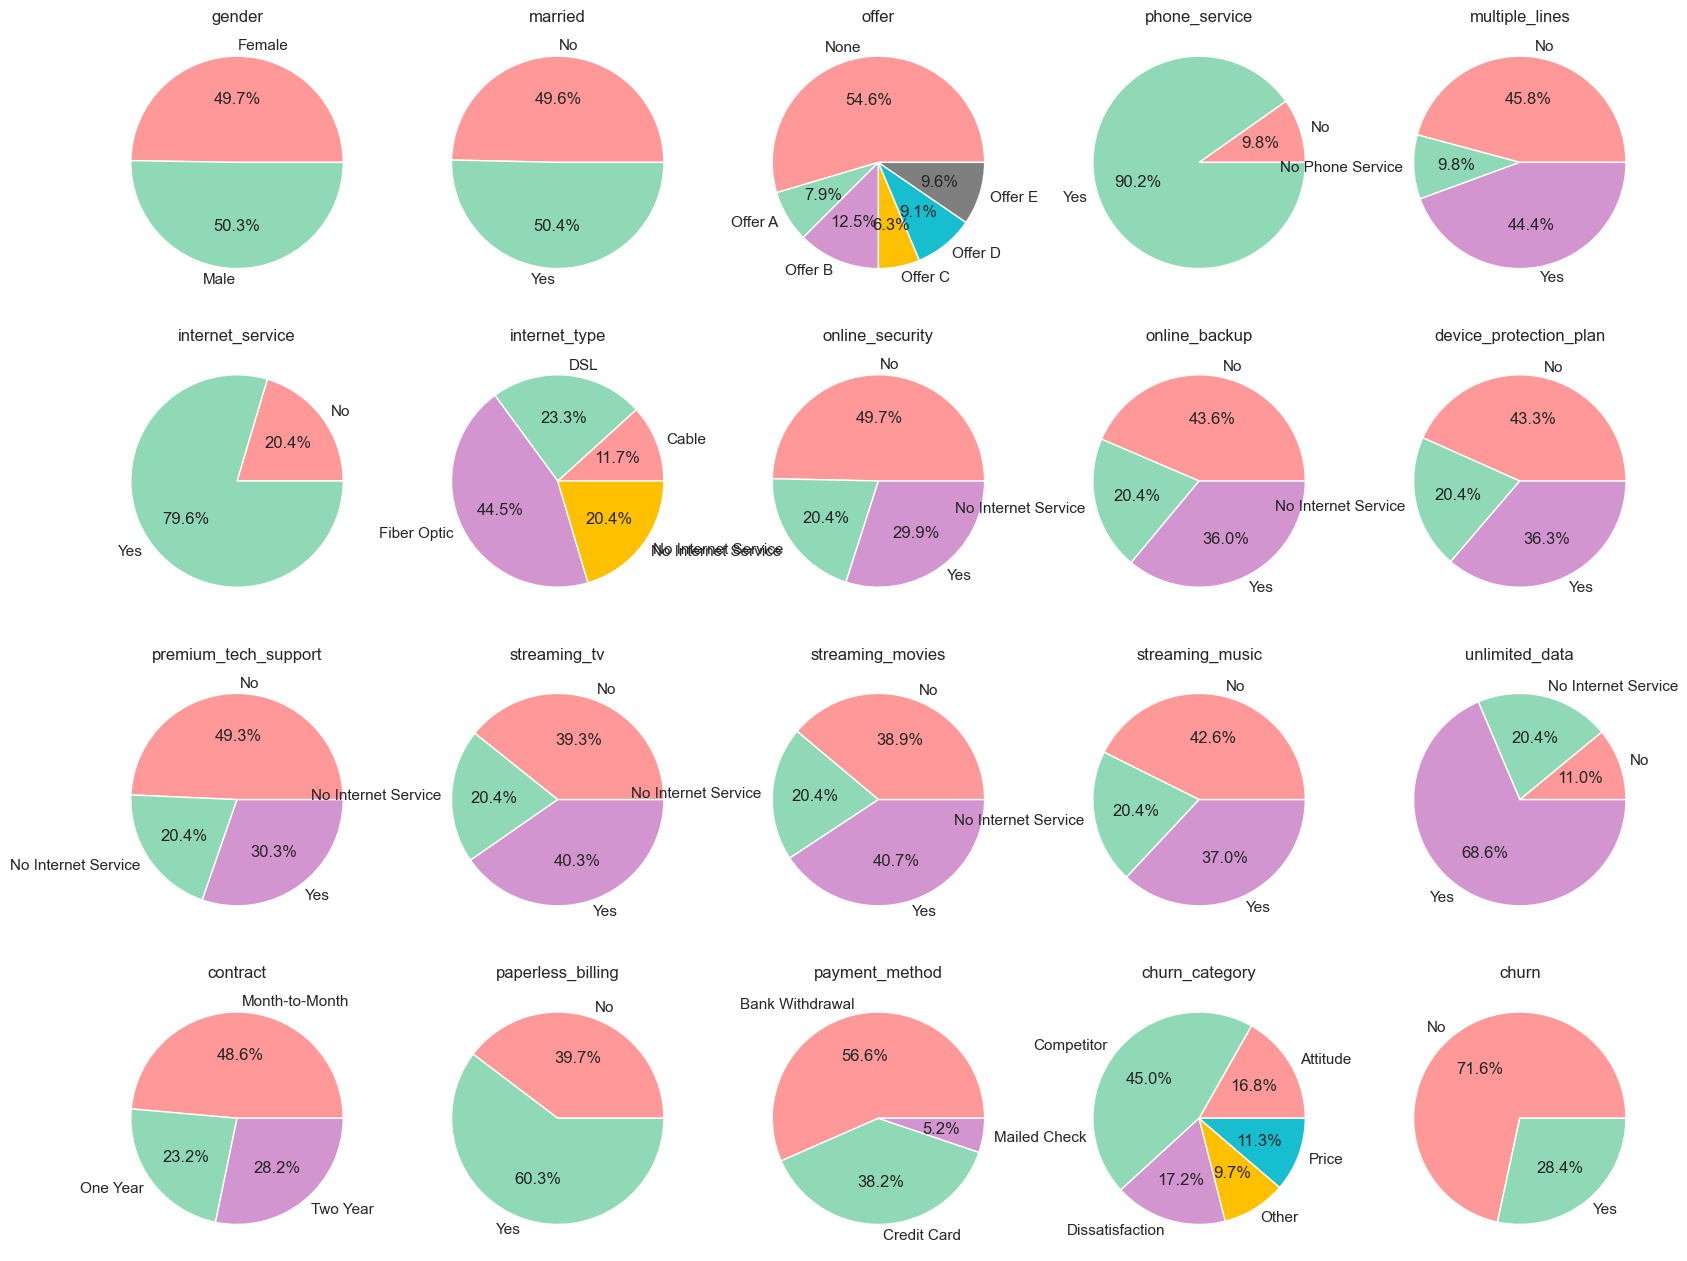

In [24]:
object_col = ['gender', 'married', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type',
              'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv',
              'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method',
              'churn_category', 'churn']
#_ = df[object_col]
colors = ['#ff9999', '#8fd9b6', '#d395d0', '#ffc000', '#17becf', '#7f7f7f']

fig = plt.figure(figsize = (20, 20))


i = 1
for a in prc[object_col].columns:
    plt.subplot(5, 5, i)
    ax = prc.groupby([a]).size().plot(kind = 'pie', autopct = '%.1f%%', colors = colors)
    ax.set(xlabel = None, ylabel = None)
    plt.title(str(a), loc='center')
    i += 1

### 데이터 인코딩

*라벨 인코딩*

원핫인코딩을 쓰면 좋을지 라벨 인코딩을 쓰면 좋을지

라벨 인코딩으로 결정

데이터 인코딩 후 상관관계 확인, 컬럼 선정하여 훈련세트와 테스트 세트 나눠 모델 학습

In [18]:
# 라벨 인코딩을 적용할 변수의 리스트 : object_col
object_col = ['gender', 'married', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type',
              'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv',
              'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method',
              'churn_category', 'churn', 'customer_status']

# fit()과 transform()으로 라벨 인코딩을 수행
for feature in object_col:
    # LabelEncoder를 객체로 생성
    encoder = LabelEncoder()
    # fit, transform 메소드를 통한 레이블 인코딩
    encoder.fit(prc[feature])
    prc[feature] = encoder.transform(prc[feature])
    
# Label Encoding 결과 재복원
# print(encoder.inverse_transform(df["married"]))

In [19]:
# 컬럼 삭제
prc=prc.drop(columns=['customer_id','churn_category','churn_reason','zip_code','longitude','latitude','city','customer_status'])

<AxesSubplot: >

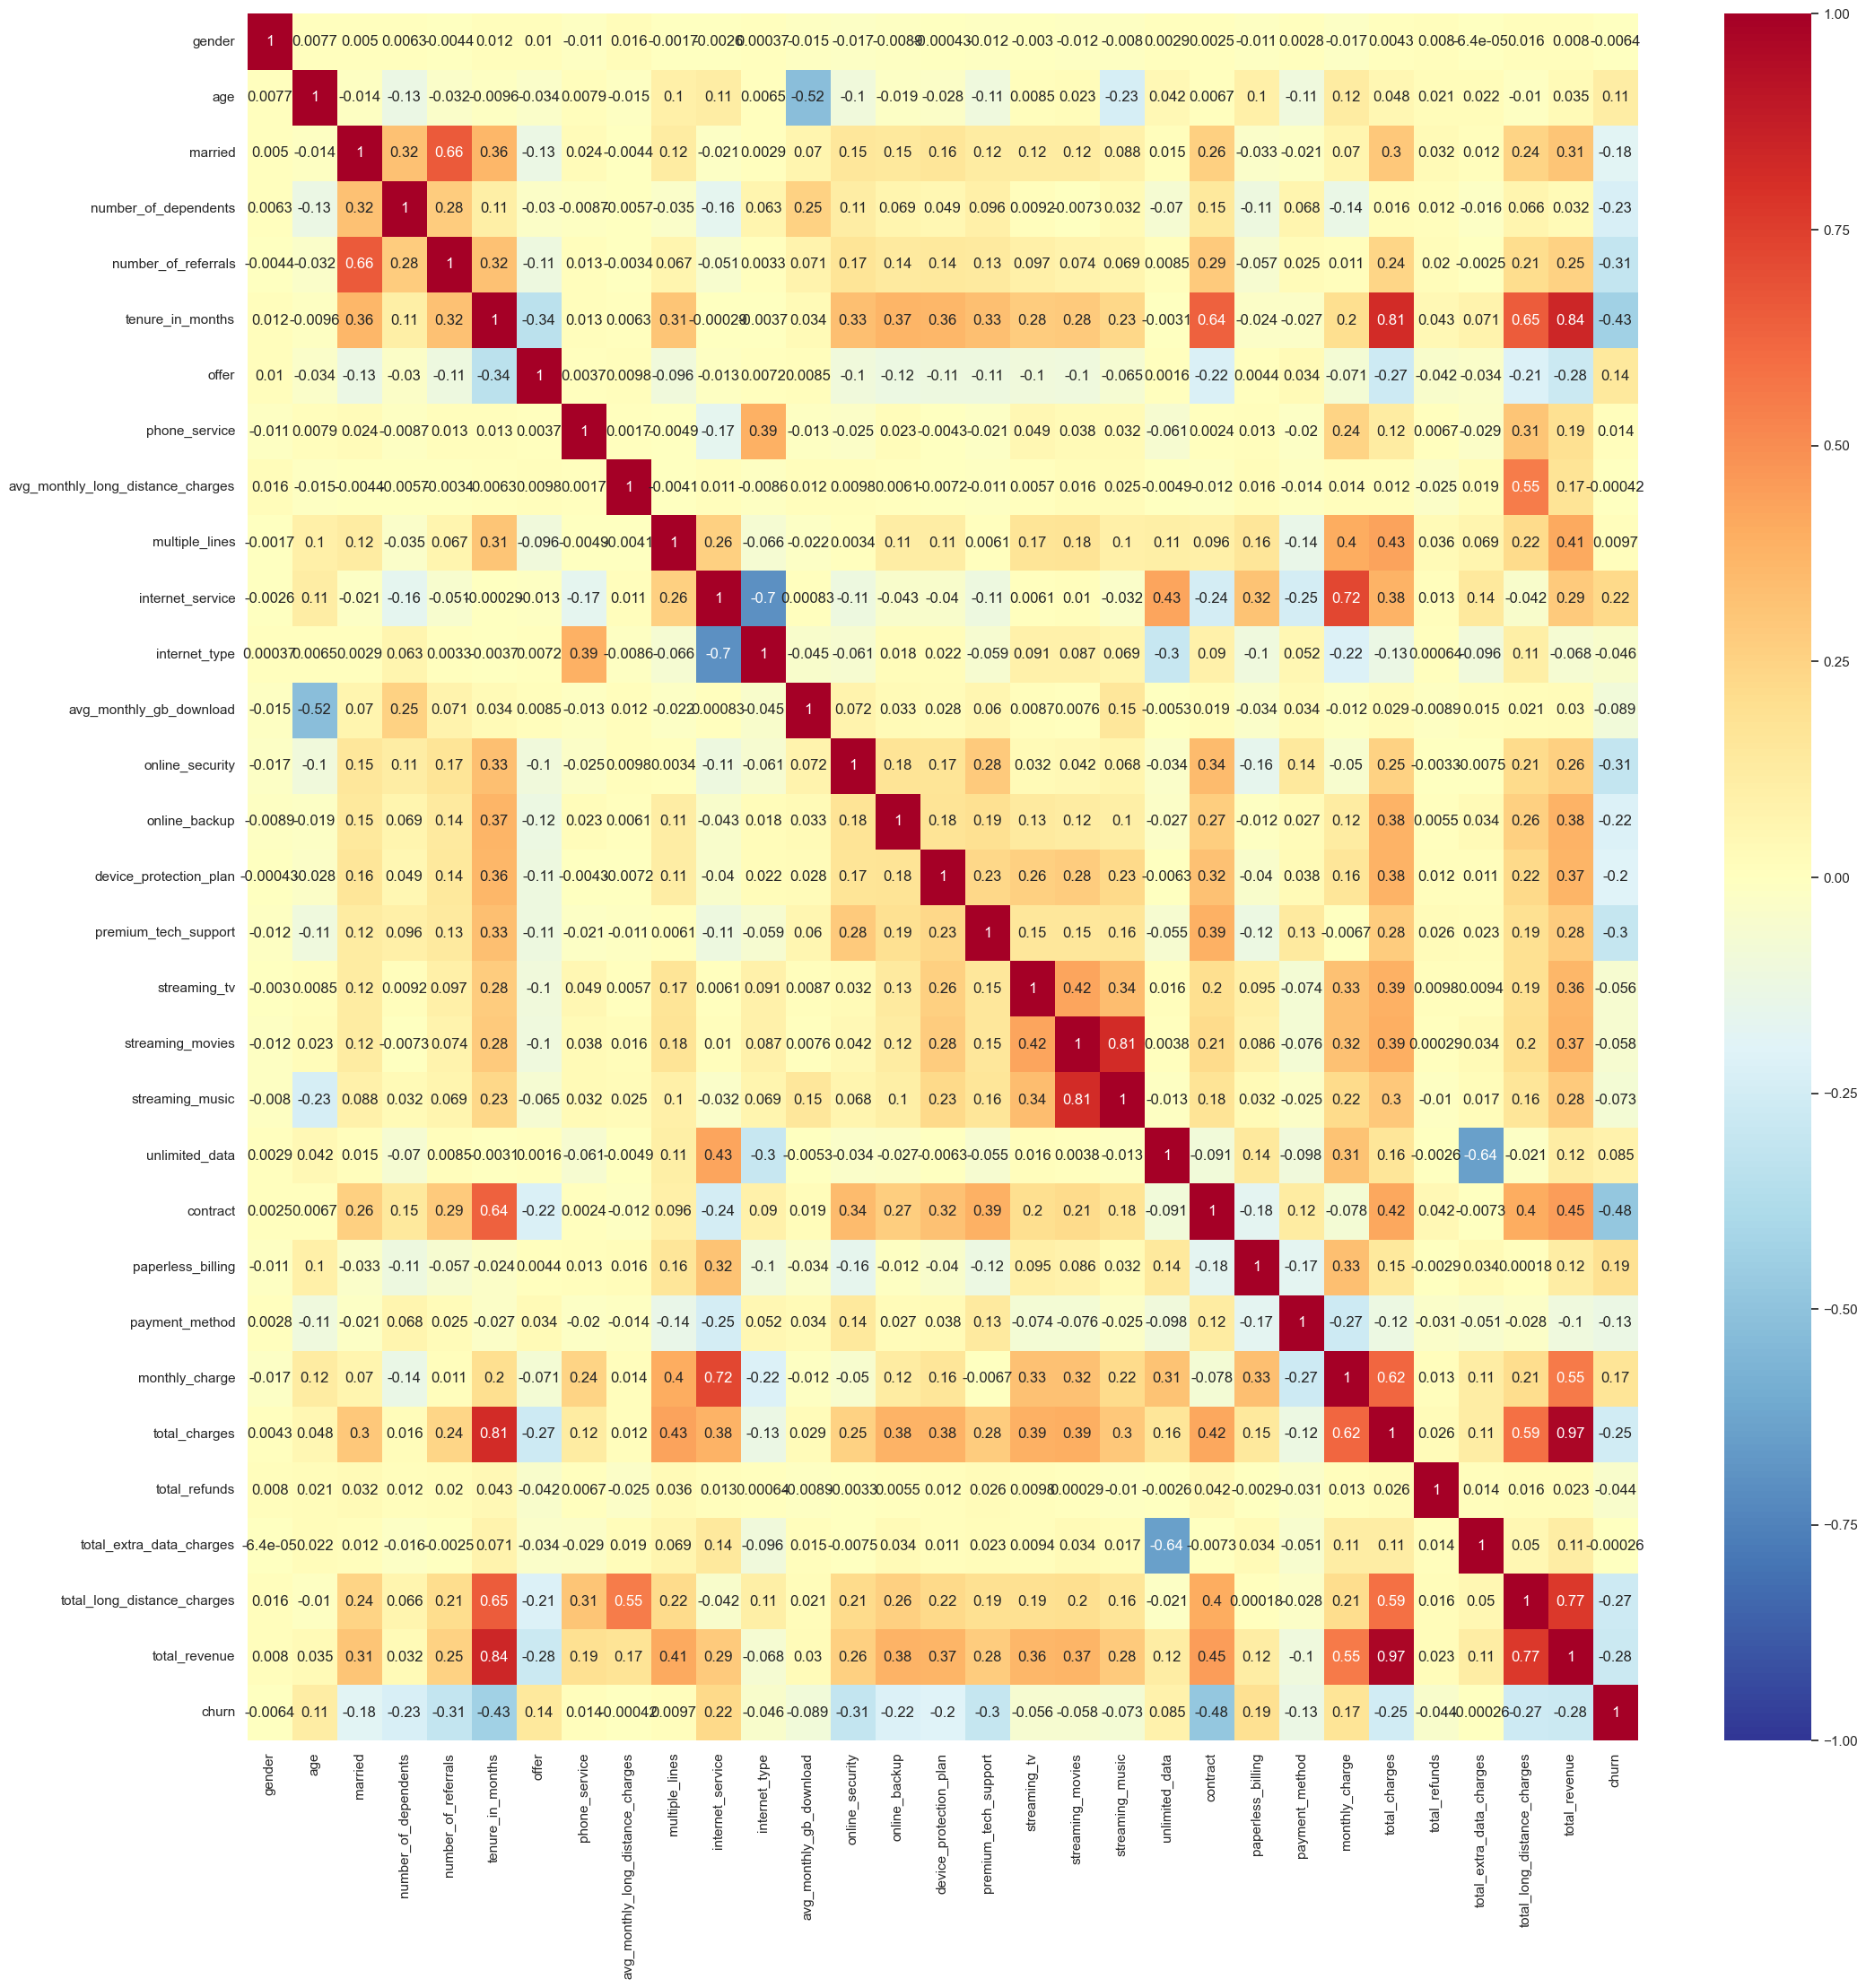

In [20]:
# 상관계수 시각화
raw = prc.corr()
plt.figure(figsize = (25,25))
sns.heatmap(raw,
              annot = True,     # 실제 값 화면에 나타내기
              cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
              vmin = -1, vmax = 1, # 컬러차트 -1 ~ 1 범위로 표시
              )

**약한 상관관계**

total_refunds가 모든 컬럼과 상관관계가 약합니다.


**강한 상관관계**

married & number_of_referrals : 0.67

monthly_charge & internet_service : 0.72

tenure_in_months & total_revenue : 0.85

avg_monthly_long_distance_charges & total_long_distance_charges : 0.53

monthly_charge & total_revenue : 0.56

monthly_charge & total_charges : 0.62

streaming_music & streaming_movies : 0.85  -> streaming_music을 이용하는 고객은 streaming_movies도 이용할 가능성이 높습니다.

total_charges & totla_revenue : 0.97 -> 총 수익은 누적 금액과 큰 관련이 있음은 당연한 이야기

Total Revenue= Total Charges - Total Refurnds + Total Extra Data Charges + Total Lond Distance Charges

**음의 강한 상관관계**

internet_type & internet_service : - 0.7

avg_monthly_gb_download & age : - 0.52

total_extra_data_charges & unlimited_data : - 0.64


In [21]:
# 컬럼 삭제
prc=prc.drop(columns=['total_refunds'])

In [ ]:
# 데이터프레임 csv로 저장
prc.to_csv('telecom_final.csv', index=False)